<a href="https://colab.research.google.com/github/Garg19/CCGAN/blob/master/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/My Drive/UTKFace1.zip"

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D,Embedding,Multiply,Concatenate
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from keras.applications import VGG16
import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt

In [ ]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

In [ ]:
GENERATE_RES = 4
GENERATE_SQUARE = 32 * GENERATE_RES 
IMAGE_CHANNELS = 3
PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16
SEED_SIZE = 100
DATA_PATH = '/content/UTKFace1/labeled'
OUT_PATH = '/content/drive/My Drive/NewGAN'
EPOCHS = 500
BATCH_SIZE = 32
BUFFER_SIZE = 60000
num_classes = 120
training_binary_path = os.path.join(OUT_PATH,f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')
labeled_binary_path = os.path.join(OUT_PATH,f'labeled_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')
if not os.path.isfile(labeled_binary_path):
  start = time.time()
  print("Loading training images...")

  training_data = []
  labels_data = []
  faces_path = DATA_PATH
  for filename in tqdm(os.listdir(faces_path)):
      path = os.path.join(faces_path,filename)
      image = Image.open(path).resize((GENERATE_SQUARE,GENERATE_SQUARE),Image.ANTIALIAS)
      training_data.append(np.asarray(image))
      labels_data.append(float(filename.split('_',1)[0]))
  training_data = np.reshape(training_data,(-1,GENERATE_SQUARE,
            GENERATE_SQUARE,IMAGE_CHANNELS))
  training_data = training_data.astype(np.float32)
  training_data = training_data / 127.5 - 1.


  print("Saving training image binary...")
  np.save(training_binary_path,training_data)
  np.save(labeled_binary_path,labels_data)
  elapsed = time.time()-start
else:
  print("Loading previous training pickle...")
  training_data = np.load(training_binary_path)
  labels_data = np.load(labeled_binary_path)
train_dataset = tf.data.Dataset.from_tensor_slices((training_data,labels_data)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

  0%|          | 37/14749 [00:00<00:40, 366.44it/s]

Loading training images...


100%|██████████| 14749/14749 [00:26<00:00, 547.60it/s]


Saving training image binary...


In [ ]:
def build_generator(seed_size, channels):
    model = Sequential()

    model.add(Dense(4*4*256,activation="relu",input_dim=seed_size))
    model.add(Reshape((4,4,256)))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
  
    model.add(UpSampling2D())
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    if GENERATE_RES>1:
      model.add(UpSampling2D(size=(GENERATE_RES,GENERATE_RES)))
      model.add(Conv2D(128,kernel_size=3,padding="same"))
      model.add(BatchNormalization(momentum=0.8))
      model.add(Activation("relu"))

    model.add(Conv2D(channels,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))

    return model

def build_cgan_generator(z_dim,channels):

    z = Input(shape=(z_dim, ))
    label = Input(shape=(1, ))
    label_embedding = Embedding(num_classes, z_dim, input_length=1)(label)
    label_embedding = Flatten()(label_embedding)
    joined_representation = Multiply()([z, label_embedding])
    generator = build_generator(z_dim,channels)
    conditioned_img = generator(joined_representation)
    return Model([z, label], conditioned_img)



def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=[image_shape[0],image_shape[1],image_shape[2]*2], 
                     padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model
def build_cgan_discriminator(image_shape):

    img = Input(shape=image_shape)
    label = Input(shape=(1, ))
    
    label_embedding = Embedding(num_classes,np.prod(image_shape),input_length=1)(label)
    label_embedding = Flatten()(label_embedding)
    # Reshape label embeddings to have same dimensions as input images
    label_embedding = Reshape(image_shape)(label_embedding)

    # Concatenate images with their label embeddings
    concatenated = Concatenate(axis=-1)([img, label_embedding])

    discriminator = build_discriminator(image_shape)

    # Classify the image-label pair
    classification = discriminator(concatenated)
    return Model([img, label], classification)

In [ ]:
def save_images(cnt,noise):
  image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 3), 
      255, dtype=np.uint8)
  
  generated_images = generator.predict(noise)

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] = generated_images[image_count] * 255
        image_count += 1

          
  output_path = os.path.join(OUT_PATH,'output')
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  
  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)

tf.Tensor([[0.6373402]], shape=(1, 1), dtype=float32)


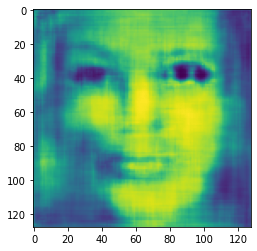

In [ ]:
generator = tf.keras.models.load_model("/content/drive/My Drive/NewGAN/face_generator.h5")

noise = tf.random.normal([1, SEED_SIZE])
label = np.random.uniform(0,num_classes,(1, 1))
generated_image = generator([noise,label], training=False)

plt.imshow(generated_image[0, :, :, 0])
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)

discriminator = tf.keras.models.load_model("/content/drive/My Drive/NewGAN/face_discriminrator.h5")
decision = discriminator([generated_image,label])
print (decision)

generator_optimizer = tf.keras.optimizers.Adam(1e-5,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-5,0.5)
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
@tf.function
def train_step(images,labels):
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator([seed,labels], training=True)

    real_output = discriminator([images,labels], training=True)
    fake_output = discriminator([generated_images,labels], training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  return gen_loss,disc_loss

In [ ]:
def train(dataset, epochs):
  fixed_seed = tf.random.normal([1, SEED_SIZE])
  fixed_seed = tf.repeat(fixed_seed,28,0)
  fixed_seed_labels = np.arange(1,85,3)
  start = time.time()

  for epoch in range(epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []
    k = 0;
    for image_batch in dataset.as_numpy_iterator():
      if image_batch[0].shape[0]==BATCH_SIZE:
        t = train_step(image_batch[0],image_batch[1])
        gen_loss_list.append(t[0])
        disc_loss_list.append(t[1])
        k = k+1
    print(k)
    if (epoch+1)%50==0:
      print(fixed_seed_labels)
      generator.save(os.path.join(OUT_PATH,"face_generator.h5"))
      discriminator.save(os.path.join(OUT_PATH,"face_discriminrator.h5"))
    
    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss},{hms_string(epoch_elapsed)}')
    save_images(epoch,[fixed_seed,fixed_seed_labels])
  elapsed = time.time()-start
  print (f'Training time: {hms_string(elapsed)}')

In [ ]:
train(train_dataset, EPOCHS)

460
Epoch 1, gen loss=0.6919736266136169,disc loss=1.009616494178772,0:01:38.44
460
Epoch 2, gen loss=0.693049967288971,disc loss=1.006645679473877,0:01:35.82
460
Epoch 3, gen loss=0.6928963661193848,disc loss=1.0070966482162476,0:01:35.64
460
Epoch 4, gen loss=0.6923174262046814,disc loss=1.0080950260162354,0:01:35.93
460
Epoch 5, gen loss=0.6930860280990601,disc loss=1.0065641403198242,0:01:35.26
460
Epoch 6, gen loss=0.6925548911094666,disc loss=1.0080682039260864,0:01:35.44
460
Epoch 7, gen loss=0.6920915842056274,disc loss=1.0100011825561523,0:01:35.37
460
Epoch 8, gen loss=0.6921079754829407,disc loss=1.010901689529419,0:01:35.32
460
Epoch 9, gen loss=0.6915024518966675,disc loss=1.011186122894287,0:01:35.47
460
Epoch 10, gen loss=0.6916275024414062,disc loss=1.011337399482727,0:01:35.28
460
Epoch 11, gen loss=0.6925034523010254,disc loss=1.0083686113357544,0:01:35.46
460
Epoch 12, gen loss=0.6925773024559021,disc loss=1.008119821548462,0:01:35.91
460
Epoch 13, gen loss=0.6930470

In [ ]:
noise = tf.random.normal([1, SEED_SIZE])
noise = tf.repeat(noise,28,0)
labels = np.arange(1,85,3)
save_images(-1,[noise,labels])

In [ ]:
print(labels)

[ 1  4  7 10 13 16 19 22 25 28 31 34 37 40 43 46 49 52 55 58 61 64 67 70
 73 76 79 82]
